In [68]:
%matplotlib inline
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import torch.optim as optim
from torchmetrics import Accuracy
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter


import matplotlib.pyplot as plt
import numpy as np

# Settings 

torch.set_printoptions(precision=3)

In [21]:
transform_normalize = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                download=True, transform=transform_normalize)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                 download=True, transform=transform_normalize)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64,
                                            shuffle=False, num_workers=2)

In [17]:
x_train = torch.stack([sample[0] for sample in ConcatDataset([mnist_trainset])])

x_test = torch.stack([sample[0] for sample in ConcatDataset([mnist_testset])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


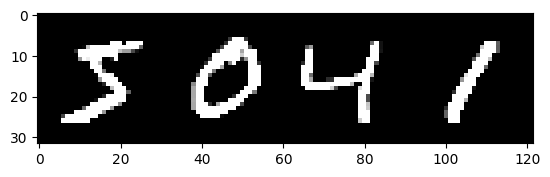

In [14]:
# show image of shape (1, 28, 28)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(x_train[0:4]))

# LeNet-5
### for MNIST data set

In [25]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x, return_intermediate=False):
        outputs = {}

        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        outputs['conv1'] = x
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        outputs['conv2'] = x
        x = x.view(-1, self.num_flat_features(x))
        outputs['flatten'] = x
        x = F.relu(self.fc1(x))
        outputs['fc1'] = x
        x = F.relu(self.fc2(x))
        outputs['fc2'] = x
        x = self.fc3(x)
        outputs['fc3'] = x

        if return_intermediate:
            return outputs, x
        else:
            return  x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)
    
    

In [27]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))

In [30]:
# To visualize layers of the network
vis_model = LeNet()
# pass single image through the network
outs, x_out = vis_model(x_train[0:1], return_intermediate=True)

# Layer 1 - Conv2d - before training

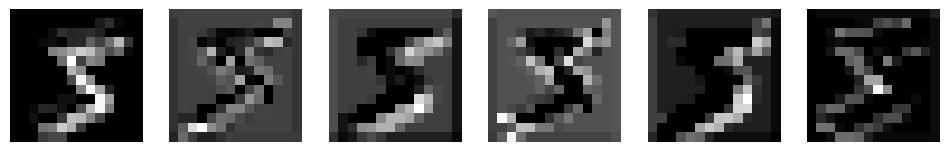

In [31]:
feature_maps = outs['conv1'].detach().cpu().numpy()


fig, axes = plt.subplots(1, len(feature_maps[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

# Layer 2 - Conv2d - before training

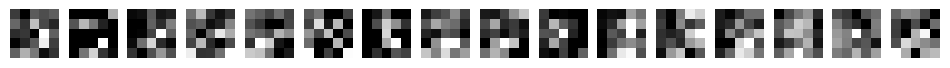

In [32]:
feature_maps = outs['conv2'].detach().cpu().numpy()

fig, axes = plt.subplots(1, len(feature_maps[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy = Accuracy(task='multiclass', num_classes=10)

accuracy = accuracy.to(device)
model1 = LeNet().to(device)
model5 = LeNet5V1().to(device)


In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)

criterion_second = nn.CrossEntropyLoss()
optimizer_second = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)




In [40]:
summary(model=model5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5V1 (LeNet5V1)                      [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

In [41]:
summary(model=model1, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet (LeNet)                            [1, 1, 28, 28]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
├─Conv2d (conv2)                         [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
├─Linear (fc1)                           [1, 400]             [1, 120]             48,120               True
├─Linear (fc2)                           [1, 120]             [1, 84]              10,164               True
├─Linear (fc3)                           [1, 84]              [1, 10]              850                  True
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.30

In [75]:
# Track the loss and accuracy
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = f'LeNet5_MNIST_{timestamp}'
model_name = 'LeNet5'
log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
log_writer = SummaryWriter(log_dir=log_dir)

In [76]:

for epoch in range(5):  # loop over the dataset multiple times
    train_loss, train_acc = 0, 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)

        model1.train()
        # model5.train()

        # y_pred = model5(X)
        y_pred = model1(X)

        loss = criterion(y_pred, y)
        train_loss += loss.item()

        acc = accuracy(y_pred, y)
        train_acc += acc

        optimizer_second.zero_grad()
        loss.backward()
        optimizer_second.step()
    
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)
    log_writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss}, global_step=epoch)
    log_writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc}, global_step=epoch)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    

Epoch 1, Loss: 1.7277, Accuracy: 0.4366
Epoch 2, Loss: 0.3014, Accuracy: 0.9084
Epoch 3, Loss: 0.1744, Accuracy: 0.9460
Epoch 4, Loss: 0.1282, Accuracy: 0.9604
Epoch 5, Loss: 0.1041, Accuracy: 0.9676


In [36]:

for epoch in range(5):  # loop over the dataset multiple times
    
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to the correct device
        model5.train()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


print('Finished Training')

Epoch [1/10], Loss: 0.0312, Accuracy: 98.97%
Epoch [2/10], Loss: 0.0255, Accuracy: 99.18%
Epoch [3/10], Loss: 0.0233, Accuracy: 99.21%
Epoch [4/10], Loss: 0.0194, Accuracy: 99.35%
Epoch [5/10], Loss: 0.0156, Accuracy: 99.51%
Finished Training


In [53]:
x = x_train[0:1].to(device)
outs_trained, perdictions = model1(x, return_intermediate=True)

# Layer 1 - Conv2d - after training

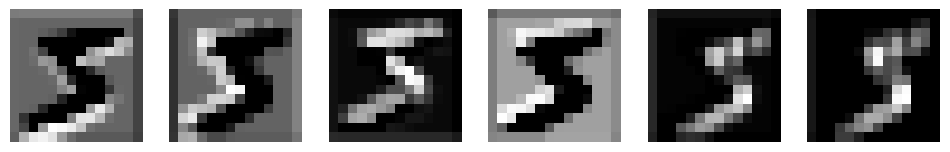

In [59]:
feature_maps_trained = outs_trained['conv1'].detach().cpu().numpy()


fig, axes = plt.subplots(1, len(feature_maps_trained[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps_trained[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

# Layer 2 - Conv2d - after training

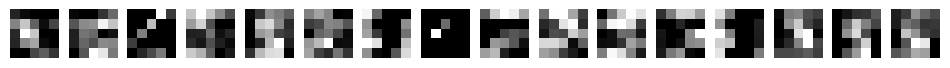

In [60]:
feature_maps_trained = outs_trained['conv2'].detach().cpu().numpy()

fig, axes = plt.subplots(1, len(feature_maps_trained[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps_trained[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

In [77]:
%load_ext tensorboard
%tensorboard --logdir={log_dir}

In [40]:
torch.save(model5.state_dict(), 'model.pth')

In [72]:
# Clean cude
torch.cuda.empty_cache()

# CIFAR10